# 📈 Weak White Noise (WWN) & Stock Returns

This notebook covers:

- **Weak White Noise:** what it is and how to simulate it
- **Diagnostics:** the series should have mean ~ 0, constant variance, no autocorrelation between lags
- **Testing it with real data:**  pulling prices with `yfinance`, building log returns, and testing:
  - Prices: typically **non-stationary** (*I(1)*)
  - Log returns: often **stationary** (roughly *I(0)*)

---

## What is Weak White Noise?

A process $\varepsilon_t$ is **weak white noise** if:

- $E$[$\varepsilon_t$] = 0
- $Var$($\varepsilon_t$) = $\sigma^2$ < $\infty$
- $Cov$ ($\varepsilon_t$, $\varepsilon_{t-h}$) = 0 for all $h$ $\neq$ 0



---


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import yfinance as yf

np.random.seed(41)

## 1) Simulate Weak White Noise

Let’s generate $\varepsilon_t$ $\sim$ $\text{i.i.d.}$ $N$(0, $\sigma^2$) as example.


In [2]:
n_obs = 10000
sigma = 1.0

eps = np.random.normal(loc=0.0, scale=sigma, size=n_obs)
eps_series = pd.Series(eps, name="epsilon")

print(eps_series.head())

0   -0.270712
1    0.104848
2    0.250528
3   -0.925200
4    0.567144
Name: epsilon, dtype: float64


## 2) Visualize WWN

We expect to see a mean-reverting **noise** with no trends and, in the histogram, something that mildly resembles a normal curve as `n_obs` increase.

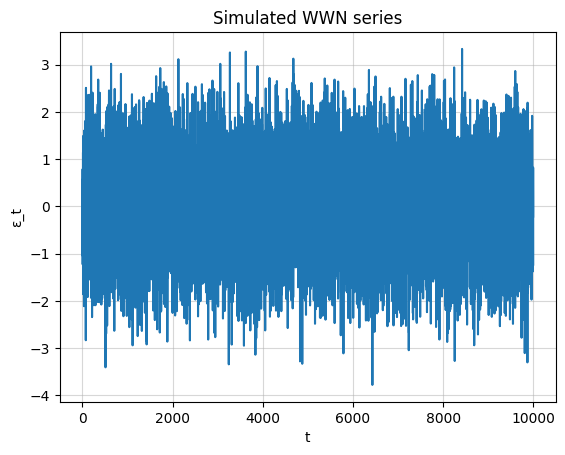

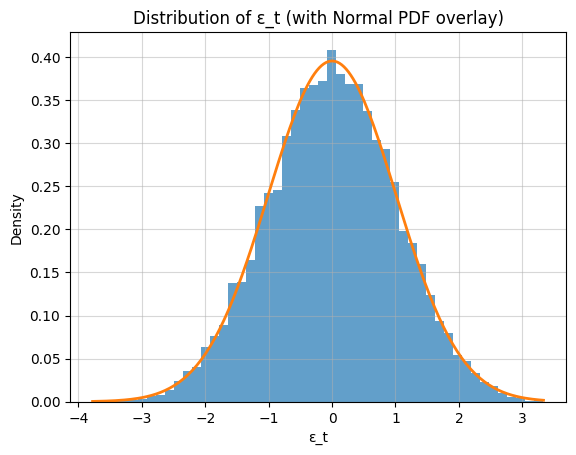

In [3]:
plt.plot(eps_series)
plt.title("Simulated WWN series")
plt.xlabel("t")
plt.ylabel("ε_t")
plt.grid(True, alpha=0.5)
plt.show()

# Histogram with normal curve for reference
plt.hist(eps_series, bins=50, density=True, alpha=0.7)
x = np.linspace(eps_series.min(), eps_series.max(), 200)
pdf = stats.norm(loc=eps_series.mean(), scale=eps_series.std()).pdf(x)
plt.plot(x, pdf, linewidth=2)
plt.title("Distribution of ε_t (with Normal PDF overlay)")
plt.xlabel("ε_t")
plt.ylabel("Density")
plt.grid(True, linestyle="-", alpha=0.5)
plt.show()


## 3) Test WWN Properties

We’ll check:

- **Mean ≈ 0** and **variance ≈ σ²**
- **No autocorrelation** (ACF)
- **Normality**—not required for the weak version of a White Noise, but let's check it anyway


Mean: 0.0005
Variance: 1.0181


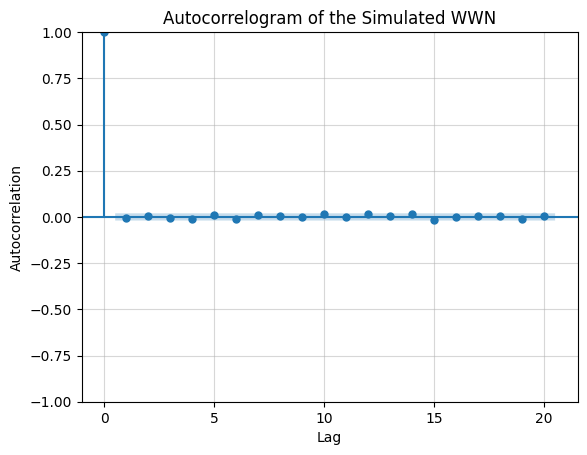

Jarque–Bera test: stat=9.435, p=0.00894


In [4]:
print("Mean:", round(eps_series.mean(), 4))
print("Variance:", round(eps_series.var(ddof=1), 4))

# Plot the Autocorrelogram
fig, ax = plt.subplots()
plot_acf(eps_series, lags=20, alpha=0.05, ax=ax)
ax.set_title("Autocorrelogram of the Simulated WWN")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.grid(True, linestyle="-", alpha=0.5)
plt.show()

#### Normality check (not required for WWN, but since we are using np.random.normal we should fail to reject H0 (normality))
jb_stat, jb_p = stats.jarque_bera(eps_series)
print(f"Jarque–Bera test: stat={jb_stat:.3f}, p={jb_p:.3g}")

## 3.1 ) Checking if variance is constant over time

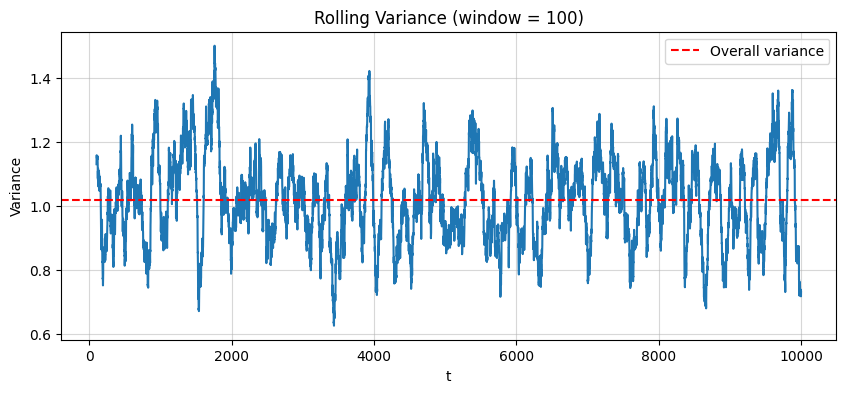

In [5]:
#Check if variance is constant over time (Homoskedasticity)
window = 100
rolling_var = eps_series.rolling(window=window).var()

plt.figure(figsize=(10, 4))
plt.plot(rolling_var)
plt.axhline(y=eps_series.var(), color="red", linestyle="--", label="Overall variance")
plt.title(f"Rolling Variance (window = {window})")
plt.xlabel("t")
plt.ylabel("Variance")
plt.legend()
plt.grid(True, linestyle="-", alpha=0.5)
plt.show()

## 4)Linking with Real Data: Do Stock Log Returns Look Like WWN?

### Stationarity & Integration

- **Prices** are said to often behave like a **random walk** → non-stationary → typically **I(1)**
- **Log returns** are differences of log prices → often **stationary**, roughly **I(0)**
  - They can be similar to a WWN in terms of: mean near zero, little autocorrelation in returns **levels**

In [6]:
# pulling data with yfinance
ticker = "SPY"
data = yf.download(ticker)
prices = data["Close"].dropna()

# Basic check data
print(prices.head())
print(prices.describe())
print(prices.info())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Ticker            SPY
Date                 
1993-01-29  24.313028
1993-02-01  24.485966
1993-02-02  24.537838
1993-02-03  24.797239
1993-02-04  24.900967
Ticker          SPY
count   8247.000000
mean     162.900146
std      145.642366
min       24.019068
25%       70.668606
50%       95.107056
75%      216.356392
max      687.390015
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8247 entries, 1993-01-29 to 2025-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     8247 non-null   float64
dtypes: float64(1)
memory usage: 128.9 KB
None


### 4.1 Obtaining Log Differences (Log Returns)

To compare with white noise, we often transform price series into **log returns**.

Given a price series $P_t$, the **log difference** is:

$$
r_t = \ln(P_t) - \ln(P_{t-1})
$$

In [9]:
log_prices = np.log(prices)
log_returns = log_prices.diff().dropna()
print(log_returns.head())
print(log_returns.describe())

Ticker           SPY
Date                
1993-02-01  0.007088
1993-02-02  0.002116
1993-02-03  0.010516
1993-02-04  0.004174
1993-02-05 -0.000694
Ticker          SPY
count   8246.000000
mean       0.000404
std        0.011761
min       -0.115887
25%       -0.004331
50%        0.000681
75%        0.005930
max        0.135578


### 4.2 Eyeballing Prices vs. Log Returns



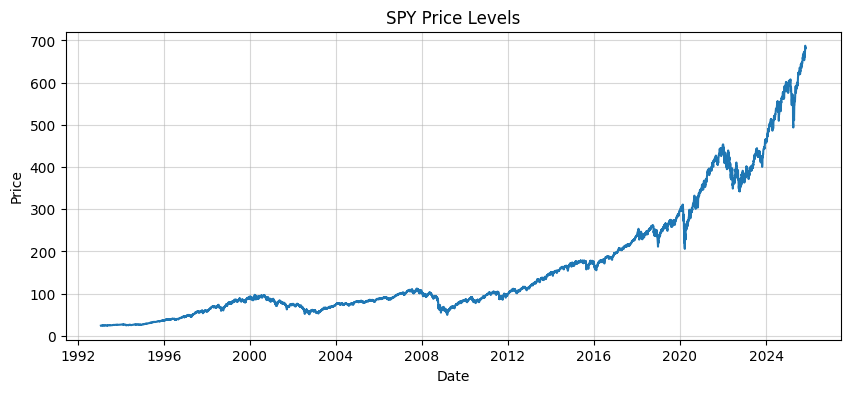

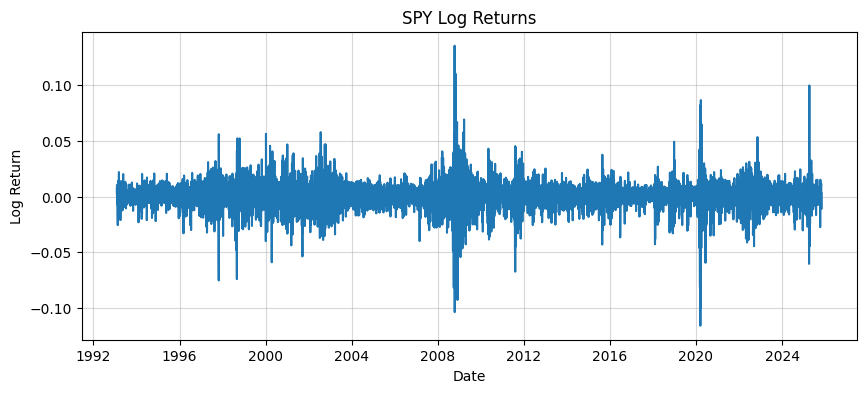

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(prices)
ax.set_title(f"{ticker} Price Levels")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True, linestyle="-", alpha=0.5)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(log_returns)
ax.set_title(f"{ticker} Log Returns")
ax.set_xlabel("Date")
ax.set_ylabel("Log Return")
ax.grid(True, linestyle="-", alpha=0.5)
plt.show()


### 4.3 Stationarity Tests (ADF)

- **ADF on prices** → we usually **fail to reject** a unit root → non-stationary
- **ADF on log returns** → we usually **reject** a unit root → stationary

(exactly what we see in the ouput)


In [26]:
def adf_report(x, name="series"):
    res = adfuller(x, autolag="AIC")
    out = {
        "series": name,
        "adf_stat": res[0],
        "p_value": res[1],
        "lags_used": res[2],
        "n_obs": res[3]
    }
    return pd.Series(out)

adf_prices = adf_report(prices, "price")
adf_lret   = adf_report(log_returns, "log_return")

pd.concat([adf_prices, adf_lret], axis=1)

,0,1
series,price,log_return
adf_stat,4.189376,-16.753238
p_value,1.0,0.0
lags_used,30,33
n_obs,8211,8207


### 4.4 Checks on Log Returns

We’ll visually check mean, variance stability, and autocorrelation:

- Returns mean is typically close to zero
- Ljung–Box on returns often shows **little** autocorrelation in levels
- Volatility clustering can still violate **strict** WWN (check squared returns)


In [27]:
print("Log returns mean:", log_returns.mean())
print("Log returns variance:", log_returns.var(ddof=1))

# Ljung–Box on returns (levels)
lb_ret = acorr_ljungbox(log_returns, lags=[10, 20, 40], return_df=True)
lb_ret


Log returns mean: Ticker
SPY    0.000404
dtype: float64
Log returns variance: Ticker
SPY    0.000138
dtype: float64


,lb_stat,lb_pvalue
10,83.604613,9.831319e-14
20,125.975594,2.207842e-17
40,174.069251,1.190263e-18


### 4.5 Autocorrelogram of SPY log returns

The ACF below shows mostly small autocorrelations, with a few lags just outside the 95% CI bands. That means returns are close to white noise, but there’s a bit of serial dependence we shouldn’t ignore.

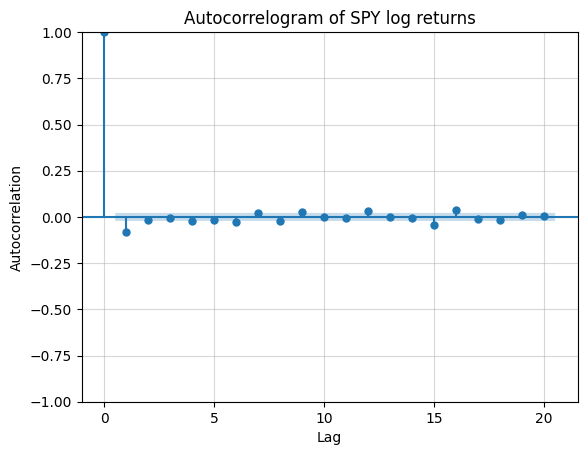

In [14]:
# Plot the Autocorrelogram
fig, ax = plt.subplots()
plot_acf(log_returns, lags=20, alpha=0.05, ax=ax)
ax.set_title("Autocorrelogram of SPY log returns")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.grid(True, linestyle="-", alpha=0.5)
plt.show()


### 4.6 Rolling variance of SPY

The 100-day rolling variance swings a lot over time. Spikes line up with stress episodes (GFC and Covid), while quiet periods sit well below the long-run average (red dashed line). Although the series mean-reverts toward there isn't a clear constance suggesting evidence of heteroskedasticity in returns.

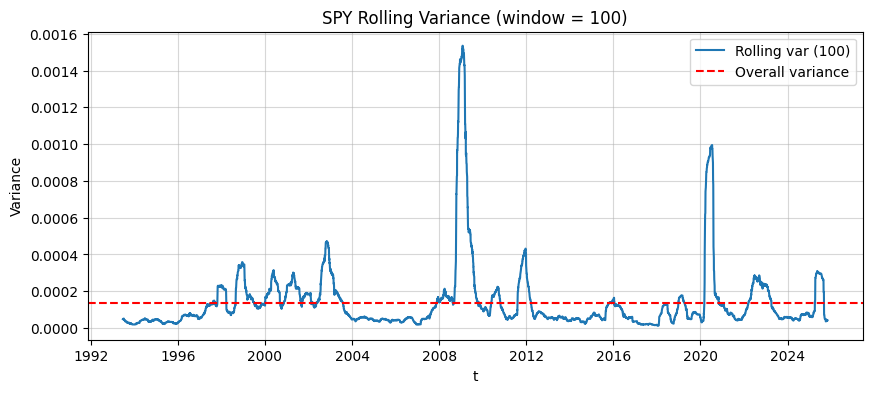

In [23]:
window = 100
spy = log_returns["SPY"]            # pick your column name here

rolling_var = spy.rolling(window=window, min_periods=window).var()

plt.figure(figsize=(10, 4))
plt.plot(rolling_var.index, rolling_var.values, label=f"Rolling var ({window})")
plt.axhline(y=spy.var(), color="red", linestyle="--", label="Overall variance")
plt.title(f"SPY Rolling Variance (window = {window})")
plt.xlabel("t")
plt.ylabel("Variance")
plt.legend()
plt.grid(True, linestyle="-", alpha=0.5)
plt.show()


## 5) Final takes

These results line up with what we usually see in financial econometrics practice.

First, looking at the **ADF tests**, the price series behaves like a **random walk** as the test statistic is close to zero and the p-value is as high as it could be (1.0), so we can’t reject the idea that prices have a unit root. And so we can affirm that stock prices are **non-stationary I(1)**, which is what theory predicts.

On the other hand, when we take **log differences** (log returns), the ADF statistic drops sharply to around −1.3^-29 with a small p-value, so we can reject the presence of unit root with confidence. This means **log returns bring us closer to a stationarity**. On this subject, however, it must be noted that the rolling-variance plots show clear volatility clustering, suggesting heteroskedasticity. Additionaly, Autocorrelogram and  the **Ljung–Box test** with extremely low p-values confirm the presence of some autocorrelation in the data.

